<div style="display: flex; align-items: center;">
    <h1 style="font-size: 3em; margin-right: 15px;">
        Physics Aware Recurrent Convolutional Neural Network (PARC): Burgers Equation Demo
    </h1>
    <div>
        <img src="../misc/VIL_logo.png" width="120" alt="Image 1" style="margin-right: 5px;" />
        <img src="../misc/uva.png" width="120" alt="Image 2" style="margin-right: 5px;" />
        <img src="../misc/iowa.png" width="120" alt="Image 3" />
    </div>
</div>

<p>
A customizable framework to embed physics in Deep Learning.
PARC's formulation is inspired by Advection-Diffusion-Reaction processes and uses an Inductive Bias approach to constrain the Neural Network.
</p>


## PARC's internal general form of Partial Differential Equation
Below is the general form of the partial differential equation that PARCv2 is learning - and its initial boundaries. In the case of the Burgers equation, we can describe the certain variables to represent the necessary points in which PARC tries to model after the equation
$$
\frac{\partial X}{\partial t} = f(X, \mu) + \epsilon
$$

- $X$ is the fields of interest - Temperature, Pressure, Reynolds, Velocities (U & V), for Burgers equation it could be a single scalar field such as fluid velocity $u(x, t)$
- $μ$ is the microstructure - the fixed parameters or material properties that influence the dynamics of the equation but does not change in time

## Modeling Burgers' Equation with PARC

This example notebook aims to demonstrate a live-action of predicting the time evolution of a single-dimension velocity field of the viscous Burgers' equation using the PARC Neural Network. The goal is to model the nonlinear transport and diffusion dynamics in a spatial and time context with learned approximateions of the physics-based derivatives instead of using traditional numerical approach (i.e. finite difference)

The notebook will guide you through from start to finish in preparing, training, and modeling the physics-based equation's prediction results. The notebook primarily covers three sections:
- loading and preparing the data for Burgers' Equation
- Using the PARC Model to learn and predict the time evolution of $u(x, t)$
- Evaluating the model's performance and compare predicted results to ground truth

## What is the Burger's Equation?

The Burgers' Equation is a fundamental partial differential equation (PDE) that is used to model the combined effects of nonlinear advection and viscous diffusion. It was first introduced as a simplified model of the Navier-Stokes equations (the governing equations for fluid motion) with fewer variable complexities (i.e. no pressure variables). It became one of the earliest equations used to model shock wave formation, turbulence, and nonlinear wave behavior in fluid dynamics. 

$$
\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}
$$

Decomposition of the equation variables:
- $u(x, t)$ describes the velocity field, also the variable that we are trying to predict
- <b>$x$</b> is the spatial coordinate, which represents the spatial location of the point we are trying to measure
- <b>$t$</b> is the time variable
- <b>$v$</b> is the viscosity coefficient, which measures the resistance to a fluid's flow

Overall, the task here is to predict the velocity at location <b>$x$</b> and time <b>$t$</b>, where <b>$\frac{\partial u}{\partial x}$</b> describes how quickly velocity <b>$u$</b> changes across space (measurement for self-advection, as velocity <b>$u$</b> is multiplied by its own derivative), and the second order partial derivative <b>$\frac{\partial^2 u}{\partial x^2}$</b> measures the curvature of the velocity <b>$u$</b> in the space, it measures how sharply the change in velocity occurs.

## Why PARC?
- As mentioned above, the PARC Neural Network excels on top of traditional numerical solvers like Finite difference methods, as it elimnates the need to manually approximates a continuous differential equation by observing the slope values amongst a hypothetically constructed evenly-spaced grid points,.

- While PINN has also been a predominant neural network solver for physics-based partial differential equations, it often struggle to balance the loss terms and may require an extensive volume of iterations to satisfy all physics contraints while minimizing the loss. Meanwhile, PARC is capable of learning the derivative terms, in this case advection and diffusion, directly from the data using Convolutional Neural Network (CNN) differentiators, and predicts forward in time the next value of the target variable by using a learned integrator. 

- To sum up, PARC is more scalable for long-term time evolution predictions, it excels both in efficiency and accuracy than traditional numeric methods and PINNs.

## Goals of this notebook
At the end of this notebook, you will be able to model fluid dynamics via the Burgers' equation to simulate wave propagation, shock formation, and even traffic flow modeling with the computational power of the Parc neural network, happy modeling!

## Setting Up

This document serves as a guide to training a PARC model for the Burgers equation. Here are the initial steps to take before you begin training your PARC model!

Download & Prepare Data:
- Download the data from https://zenodo.org/records/13909869 and unzip it.
- Extract the downloaded data and ensure that it is placed in the following directory: `PARCtorch/PARCtorch/data`
- Make sure that the file paths at `train_dir` and `test_dir` point to the correct paths to your training and testing data, e.g. `../data/train` or `../data/test`

Install PARCtorch:
- Ensure PARCtorch is installed in your Python Environment, you could view the installation instructions [here](https://github.com/baeklab/PARCtorch/tree/main#installation)
- After the installation, install all the relevant dependencies with `!pip install -r requirements.txt` (The versions of your dependencies need to be <b>consistent</b> with our requirements, or else the script might not run!)
- Optional (only if the script doesn't run): add the root directory to the system's path so that 

In [1]:
import sys
import os
 
# Add the root directory (PARCTorch) to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

## Compute Data Normalization
When training any neural network, we must ensure that all variables are transformed onto a comparable numerical scale to prevent one variable from dominating the learning process. 

Hence, for the first step of the training we will be computing the **minimum** and **maximum** values of each variable so that they could be rescaled later. The `compute_min_max` function will store the min and max values of each varaibles in the file **b_min_max.json** for access during training and prediction

In [2]:
from pathlib import Path

from PARCtorch.data.normalization import compute_min_max

In [3]:
# Define data directories
train_dir = Path("../data/train")
test_dir = Path("../data/test")
min_max_file = train_dir.parent / "b_min_max.json"

compute_min_max([train_dir, test_dir],  # paths to access the directories containing your training and testing datasets
                min_max_file)           # path where all of the computed min-max values used for normalization will be stored 

Calculating channel-wise min and max values for normalization...
Current working directory: /sfs/gpfs/tardis/home/wkt7ne/PARCtorch/PARCtorch/demos
Total files to process: 478
Processed 100/478 files.
Processed 200/478 files.
Processed 300/478 files.
Processed 400/478 files.
Processed 478/478 files.
Channel-wise min values: [np.float64(100.0), np.float64(2.1418748489818493e-15), np.float64(2.1418748489818493e-15)]
Channel-wise max values: [np.float64(15000.0), np.float64(0.9956901262849367), np.float64(0.9956901262849367)]
Min and max values saved to '/sfs/gpfs/tardis/home/wkt7ne/PARCtorch/PARCtorch/data/b_min_max.json'.


## Loading Training Data
In this step we will be preparing the training data pipeline to feed data into the system for model training. 

The `GenericPhysicsDataset` function first reads normalized fluid-simulation data and package them into a sequence of snapshots, where each sample of the snapshot contains the state at time $t$ and the future steps frames we want the model to predict. 

We then utilizes PyTorch's `DataLoader` to abstract the complexity of the given data through batching, shuffling, and parallel data loading so that it is easier to manage and process data during model training. Its parameters are:
- **Batching** `batch_size`: Splitting large datasets into smaller, manageable batches to avoid memory overload and enable parallel processing.
- **Shuffling** `shuffle=True/False`: Randomly ordering data to prevent the model from learning patterns related to the sequence of data (particularly important in training to reduce overfitting).
- **Parallel Loading** `pin_memory=True/False`:  It allows the data to be loaded asynchronously using multiple workers, speeding up the training process by loading the next batch while the current one is being processed by the model.
- **Custom Collation** `collate_fn=custom_collate_fn`: allows customization of how batches are combined, which is essential for complex datasets that require specific handling.



In [4]:
import logging
import torch
from torch.utils.data import DataLoader

# Now import the utilities
from PARCtorch.data.dataset import (
    GenericPhysicsDataset,
    custom_collate_fn,
    InitialConditionDataset,
    initial_condition_collate_fn,
)
from PARCtorch.utilities.viz import (
    visualize_channels,
    save_gifs_with_ground_truth,
)

# Set up logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)

future_steps = 1
# Path to the min_max.json file
batch_size = 4

# Initialize the dataset
train_dataset = GenericPhysicsDataset(
    data_dirs=[train_dir],      # loading in training data
    future_steps=future_steps,  # number of times to predict 
    min_max_path=min_max_file,  # path to the min/max file with the stored normalized values
)

# Create DataLoader for training dataset
train_loader = DataLoader(
    train_dataset,                  # the training data set that the model will be trained on
    batch_size=batch_size,          # number of samples processed together
    shuffle=False,                  # whether to shuffle the order of the samples (chosen not to randomize)
    num_workers=1,                  # number of parallel subprocess to load the data (chose single)
    collate_fn=custom_collate_fn,   # return a list of tuples (batch) of initial condition values
)

2025-05-19 23:55:09,333 [INFO] Starting data validation...
2025-05-19 23:55:09,335 [INFO] Validating .npy files...
Validating files: 100%|██████████| 100/100 [00:00<00:00, 509.34it/s]
2025-05-19 23:55:09,572 [INFO] Data validation completed successfully.
2025-05-19 23:55:09,574 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 100/100 [00:00<00:00, 436.10it/s]
2025-05-19 23:55:09,806 [INFO] Total samples in dataset: 10000


## Visualizing the Data - Sanity-Check

This step is a sanity-check on one of the batches to ensure that our previous two steps - **normalization** and **data loading** were carried out correctly. 

To do so, we will be plotting out the:
- **Initial Condition** `ic`: The initial physical state of the system at time $t_0$ - the input to the model
- **Time Stamp** `t0`: The time stamp corresponding to the initial condition
- **Target Timestamp** `t1`: The target time stamp that we are trying to predict with PARC
- **Ground Truth** `target`: The ground truth data at time $t_1$, representing what the model is suppoesd to output at the predicted outcome at the future time stamp
- `channel_names`: labels for each channel, i.e. `Reynolds, u, v`
- `channel_cmaps`: list of colormaps for each channel

Channel Data Statistics:
Channel 0: IC min=0.6644295454025269, IC max=0.6644295454025269
  Step 1: min=0.6644295454025269, max=0.6644295454025269
Channel 1: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706
Channel 2: IC min=7.64794982899275e-09, IC max=0.4998920261859894
  Step 1: min=7.64794982899275e-09, max=0.49605339765548706


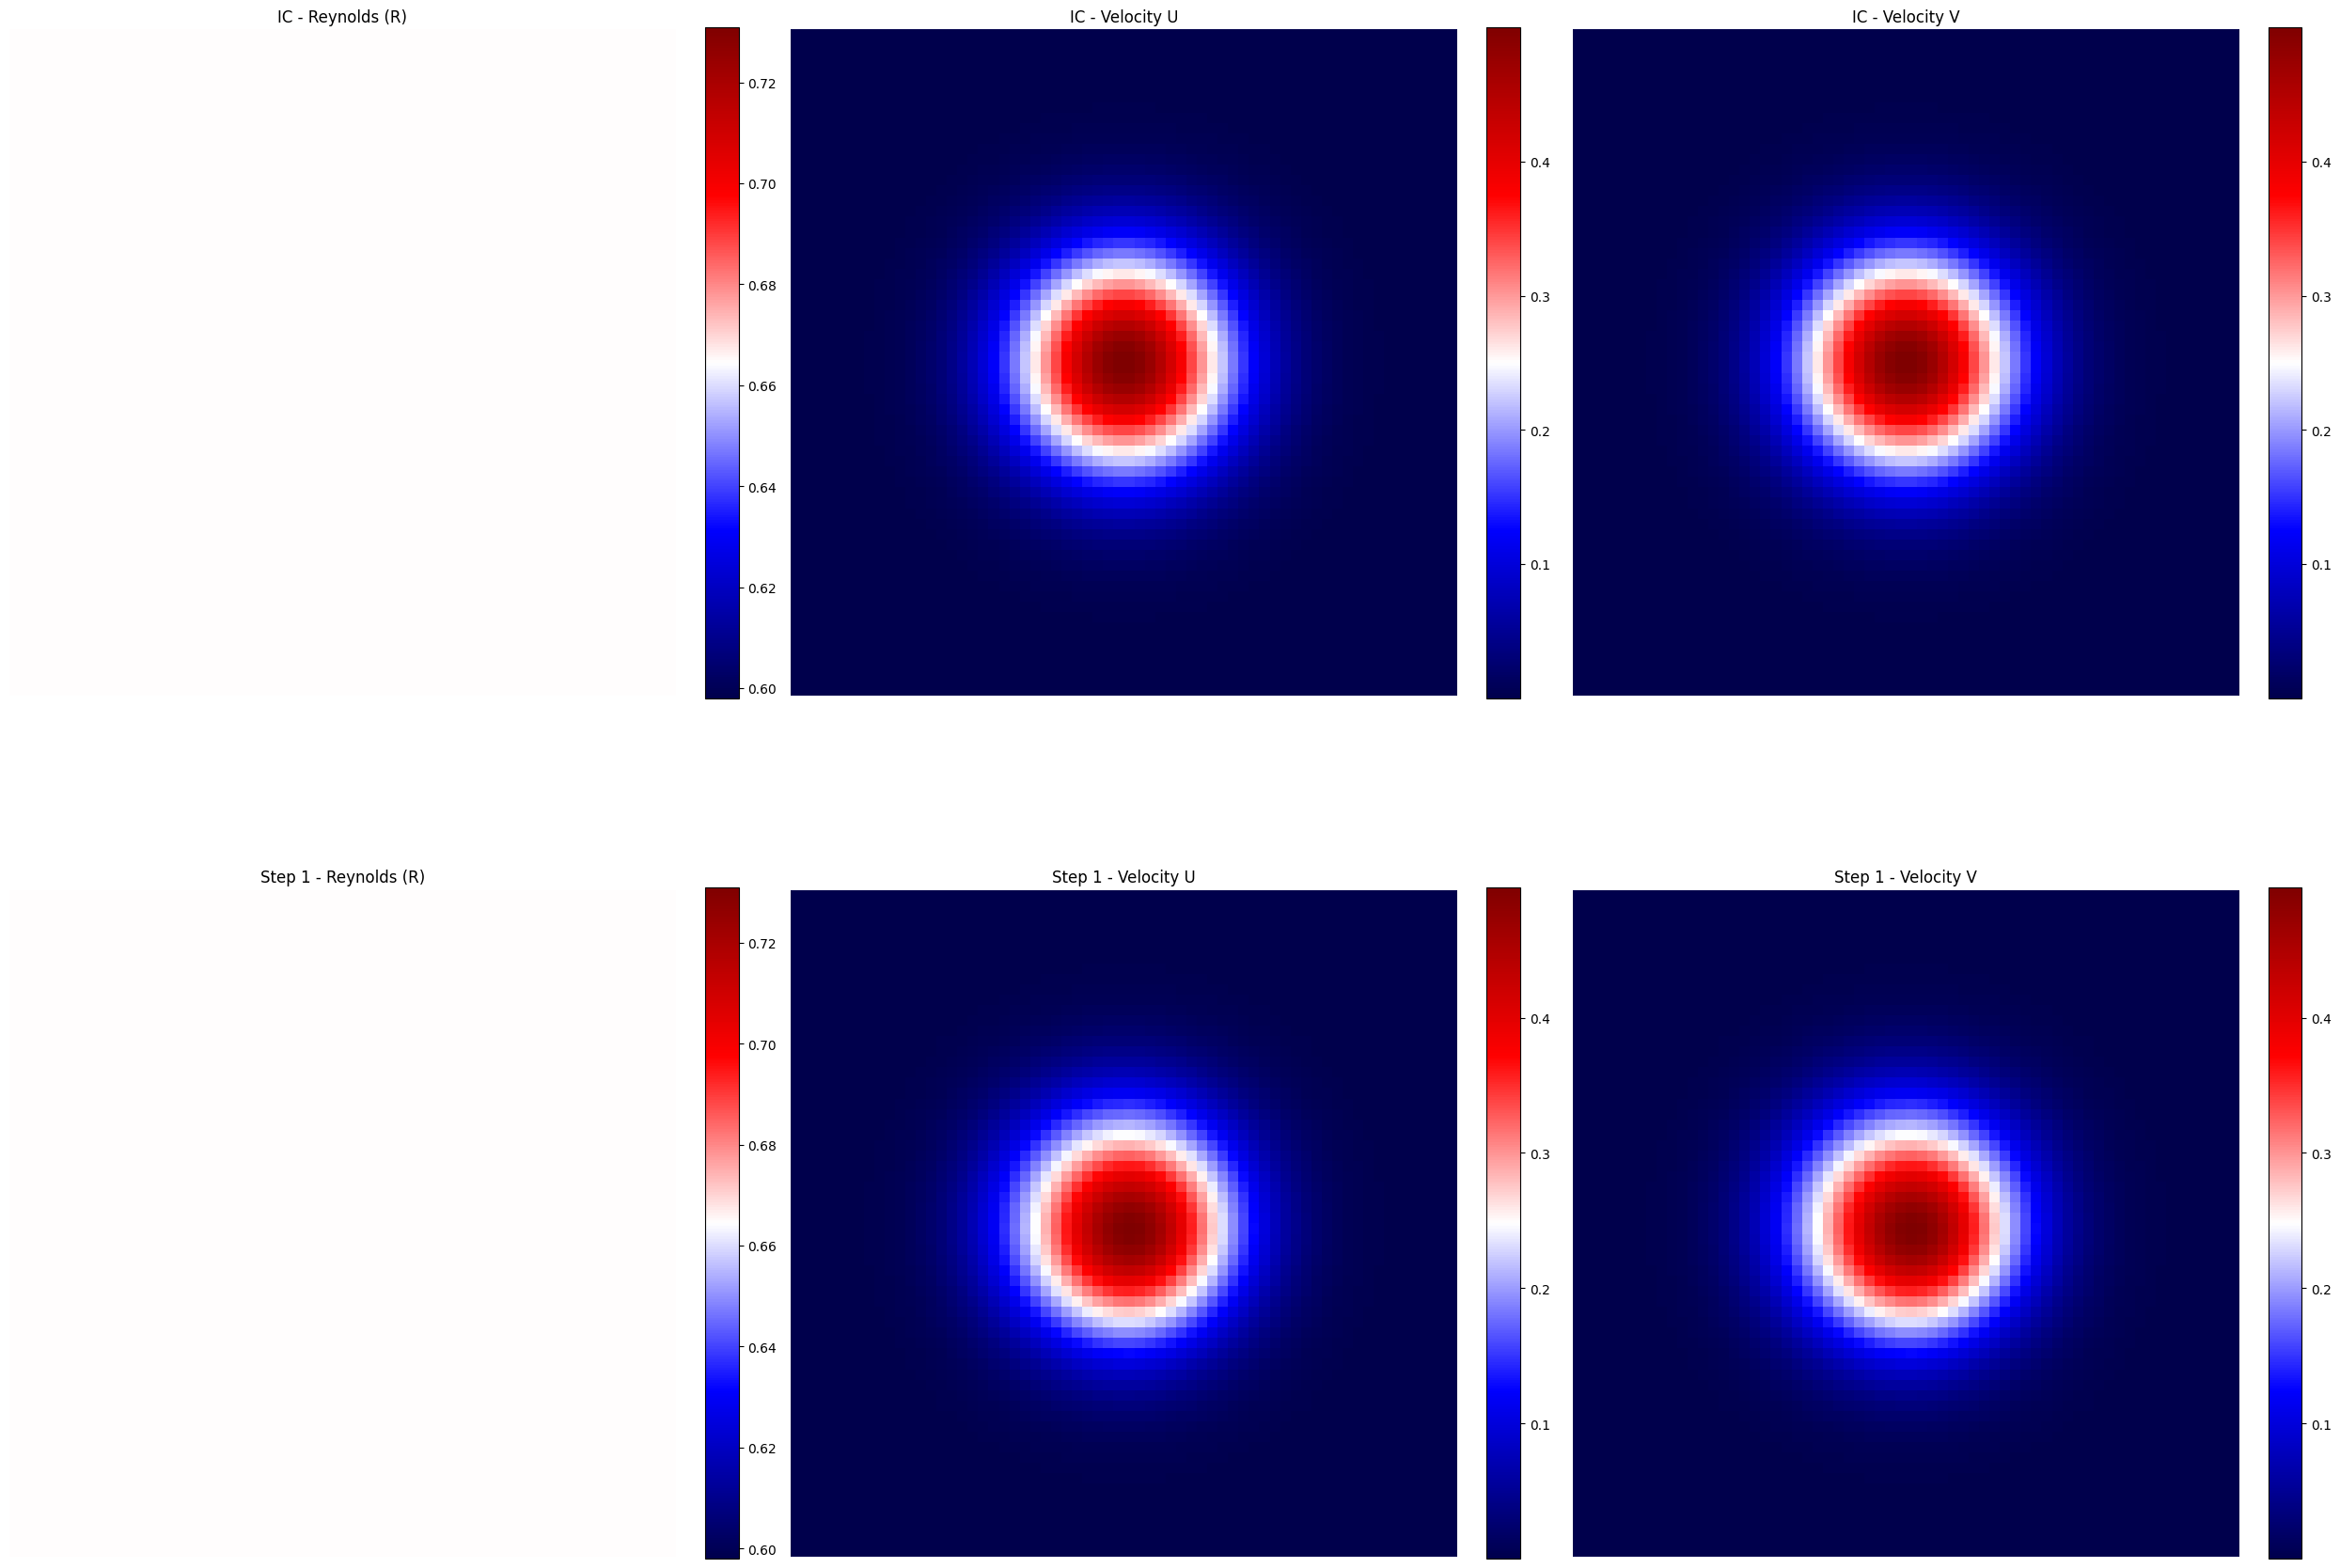

In [5]:
# Fetch a batch and visualize
for batch in train_loader:
    ic, t0, t1, target = batch
    channel_names = ["Reynolds (R)", "Velocity U", "Velocity V"]
    custom_cmaps = ["seismic", "seismic", "seismic"]

    visualize_channels(
        ic = ic,                            # Initial condition
        t0 = t0,                            # Time value corresponding to the initial condition
        t1 = t1,                            # Time value for the target variable
        target = target,                        # Ground tuth data for the state at time t1
        channel_names=channel_names,   # Names for each variable/channel
        channel_cmaps=custom_cmaps,    # Color map to use for each channel
    )
    break  # Visualize one batch for now

## Building up the PARC Model

This is the part where we construct the core building blocks of the PARCv2 model to predict the physics behind fluid dynamics - Burgers Equation. 

PARC is made up of **several** major components:
- **U-Net**: The UNet architecture is used for feature extraction, transforming the input data into a higher-dimensional representation. This helps the model capture complex patterns in the physical simulation data.
    - `block_dimensions`: the number of feature maps in each encoder layer
    - `in_channels`: Number of input channels (Reynolds, $u$, $v$)
    - `out_channels`: Number of output channels
    - `kernel_size`: Size of the convolutional kernels
    - `padding_mode`: Padding mode for convolutional layers
    - `up_block_use_concat`: Determines whether the decoder layers concatenate encoder outputs
    - `skip_connection_indices`: Specifies which encoder layers to connect to the decoder
    
- **Finite Difference**: This differentiator approximates the gradients (or derivatives) of the input data using a finite difference method, which is important for calculating advection and diffusion processes in fluid dynamics.
- **ADRDifferentiator**: This module calculates the advection and diffusion terms based on specific channel indices, such as velocity in the x and y directions (u and v).
    - `n_state_var`: Number of state variables
    - `n_fe_features`: Number of features from feature_extraction
    - `list_adv_idx`: List of channel indices to calculate Advection on
    - `list_dif_idx`: List of channel indices to calculate Diffusion on
    - `feature_extraction`: The neural network used to extract relevant features
    - `padding_mode`: type of padding used when computing derivatives
    - `finite_difference_method`: type of method to compute finite difference
    - `spade_random_noise`: whether to inject additional spatial noise during training
    
- **Heun Integrator**: Heun’s method is an improved version of Euler's method, used here to integrate the equations of motion more accurately over time.

- **Integrator**: The integrator applies Heun’s method to combine the differentiated terms and solve the Poisson equation, ensuring the physical constraints of the system are respected.
    - `clip`: whether to clip the state or velocity variable before each integration step
    - `list_poi_idx`: List of channel indices for the input and output of the PoissonBlock
    - `num_int`: Method for numerical integration
    - `list_dd_int`: List of data driven integrator
    - `padding_mode`: type of padding used when computing derivatives
    - `finite_difference_method`: type of method to compute finite difference

After constructing each components of the model, everything is wrapped under the PARCv2 class, with an embedded PyTorch loss function for `criterion` to measure the prediction error during training. Followed by an Adam optimizer with an assigned **learning rate** to auto-adjust the parameters of the model to minimize the error between the predicted values and the ground truth.

In [6]:
from PARCtorch.PARCv2 import PARCv2
from PARCtorch.differentiator.differentiator import ADRDifferentiator
from PARCtorch.differentiator.finitedifference import FiniteDifference
from PARCtorch.integrator.integrator import Integrator
from PARCtorch.integrator.heun import Heun
from PARCtorch.utilities.unet import UNet

from torch.optim import Adam

In [7]:
# Navier Stokes: p, re, u, v
# Adv: u, v
# Dif: u, v
# Poi: p

# This is the feature extractor, it transforms the raw state of the data into a set of 
# learned features that the model can use to understand and predict their future behavior
n_fe_features = 64
unet_burgers = UNet(
    block_dimensions=[64, 64 * 2, 64 * 4],        # defines how many feature maps (filters) are used at each layer of the network
    input_channels=3,                             # Number of the input channels (i.e. position, time, and noise)
    output_channels=n_fe_features,                # Number of the output channels
    kernel_size=3,                                # Default kernel size
    padding_mode="zeros",                         # Default padding mode
    up_block_use_concat=[False, True],            # Whether the decoder combines features from earlier layers
    skip_connection_indices=[0],                  # Which encoder layers are connected to the decoder
)
right_diff = FiniteDifference(padding_mode="replicate").cuda()
heun_int = Heun().cuda()

# The main component of the PARC model, it combines the feature maps from the U-Net with learned physics rules 
# to estimate the rate of change of the velocity field. Such as learning how the fluid is evolving in time due to both movement and spreading
diff_burgers = ADRDifferentiator(
    n_state_var=1,                          # 1 state variables: re. We always assume 2 velocity being the last 2 channels
    n_fe_features=n_fe_features,            # Number of features returned by the feature extraction network: 64
    list_adv_idx=[1, 2],                    # Channel indices to calculate advection: u and v
    list_dif_idx=[1, 2],                    # Channel indices to calculate diffusion: u and v
    feature_extraction=unet_burgers,        # Feature extraction network: unet_burgers
    padding_mode="constant",                # Padding mode: constant padding of zero
    finite_difference_method=right_diff,    # Using the Finite Difference Method to calculate spatial derivatives
    spade_random_noise=False,               # Not adding noise mapping and reconstruction modules
).cuda()

# This is the next step after learning the derivatives, it predicts the next state of the system given the current state and how its
# changing over time by integrating over the calculated derviatives on the previous step.
burgers_int = Integrator(
    clip=True,                             # Whether the system doesn't change its rules over time (time-invariant)
    list_poi_idx=[],                       # No external forces like gravity or wind is being considered in this model
    num_int=heun_int,                      # The Heun integration method is used to integrate the derviatives over time
    list_dd_int=[None, None, None],        # Optional overidate for derviative components
    padding_mode="constant",               # Edge padding style
    finite_difference_method=right_diff,   # Using the Finite Difference Method to calculate spatial derivatives
    poi_kernel_size=3,                     # default kernel size for Poisson
    n_poi_features=64                      # default number of features for Poisson
)
criterion = torch.nn.L1Loss().cuda()

# The architecture of the PARC Neural Network
model = PARCv2(
    differentiator=diff_burgers,  # The differentiator calculates how the variables such as advection and diffusion changes across space and time
    integrator=burgers_int,       # The integrator appends the calculated value to the velocity variable (our target variable) for the next point in time
    loss=criterion                # The loss is calculated to compare predictions with the ground truth
).cuda()
optimizer = Adam(
    params=model.parameters(), # Parameters of the PARC model that should be optimized
    lr=1e-5             # Adjusting the learning rate, or how fast should the model be updated
)

## Training the Model

This is where the training takes place, we will be calling the classes and functions defined on the previous step inside the function `train_model` to initiate the training process.

At this stage, we will be iterating over the dataset produced by `train_loader` batch-by-batch, where in each iteration we will:

- Compute model predictions
- Calculate error loss between predicted and ground truth values via the `criterion` loss function
- Update the model parameters based on error via the optimizer

In [8]:
from PARCtorch.train import train_model

# Example usage:
train_model(
    model,                      # The PARC model to train
    train_loader,               # Dataloader that feeds in training data
    criterion,                  # Loss function to calculate prediction error with the ground truth
    optimizer,                  # Optimization algorithm Adam that updates model weights
    num_epochs=1,               # Number of epochs or iterations
    save_dir=train_dir.parent,  # Directory with model logs will be saved
    app="burgers",              # Label for this training run for logging
)

Epoch 1/1: 100%|██████████| 2500/2500 [01:00<00:00, 41.32it/s, Batch Loss=5.83e-5] 


Epoch [1/1], Average Loss: 0.0006
Model weights saved at ../data/model.pth
Training losses saved at ../data/training_losses.pkl


## Loading the Model

After training the model and obtaining desired weights, we could load the model weights into new initializations of the PARC model architecture for evaluation and visualization. Eliminating the need to retrain the model each time we need to reference its weights or outcomes.

In [9]:
from PARCtorch.utilities.load import load_model_weights

# Example Usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_weights_path = train_dir.parent / "model.pth"  # Replace with your path
model = load_model_weights(model, model_weights_path, device)

Loaded model weights from '../data/model.pth'


/sfs/gpfs/tardis/home/wkt7ne/PARCtorch/PARCtorch/utilities/load.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_location=devic

## Creating the Sequence DataLoader

Now its time to test out our model on the testing dataset!

To do so, we must first redo everything we did during the training stage - but for the new testing data. We first load the test samples using the `InitialConditionDataset`, this is to only provide the initial conditions as `t=0` to allow the model to predict 'forward' in multiple future time steps without seeing intermediate values of ground truth. 

After that we again wrap them in a `DataLoader` for sample batching (same as what we did in the training stage). 

In [10]:
# Initialize the dataset
future_steps = 3
seq_dataset = InitialConditionDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
seq_loader = DataLoader(
    seq_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True, # Speeds up GPU transfers
    collate_fn=initial_condition_collate_fn,
)

2025-05-19 23:56:22,138 [INFO] Starting data validation...
2025-05-19 23:56:22,143 [INFO] Validating .npy files...
Validating files: 100%|██████████| 378/378 [00:00<00:00, 442.00it/s]
2025-05-19 23:56:23,002 [INFO] Data validation completed successfully.


## Loading Ground Truths

To evaluate the performance of our trained model, we load the ground truth values for the physics system at each time stamp for each of the test files. These are the correct fuure states that we can compare the model's predictions against. 

Here we will be using the same `GeneralPhysicsDataset` as in training but pointing it to test data. Each batch of the data will now contain the true velocity fields across time and can be used for comparison during the evaluation stage

In [11]:
# Initialize the dataset
gt_dataset = GenericPhysicsDataset(
    data_dirs=[test_dir],
    future_steps=future_steps,
    min_max_path=min_max_file,
)

# Create DataLoader for training dataset
gt_loader = DataLoader(
    gt_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
    collate_fn=custom_collate_fn,
)

2025-05-19 23:56:23,008 [INFO] Starting data validation...
2025-05-19 23:56:23,012 [INFO] Validating .npy files...
Validating files: 100%|██████████| 378/378 [00:00<00:00, 622.31it/s]
2025-05-19 23:56:23,624 [INFO] Data validation completed successfully.
2025-05-19 23:56:23,625 [INFO] Preparing dataset samples...
Listing samples: 100%|██████████| 378/378 [00:00<00:00, 552.18it/s]
2025-05-19 23:56:24,314 [INFO] Total samples in dataset: 37044


## Visualizing the Results

After predicting and gathering ground truths, we can create animated GIFs for each physical variables with `save_gifs_with_ground_truth`. The GIFs will be produced as a side-by-side animation collage with the left side showcasing the fluid motion that **PARC predicted** at each future time stamp, and the right showcasing the **true state** of the fluid motion from the ground truths data.

By observing these animations, you could get a visual grasp of, for example, how well advection waves are preserved through time, whether diffusion smooths the field realistically, and most importantly whether the PARC model **accurately predicts** the ground physical truth that occurs in the real world.

In [12]:
# Set the model to evaluation mode
model.eval()

# Define channel names and colormaps
channels = ["Reynolds", "u", "v"]  # Adjust as per your data
cmaps = ["plasma", "inferno", "magma"]  # Adjust as per your preference

# Iterate through both DataLoaders simultaneously
for seq_batch, test_batch in zip(seq_loader, gt_loader):
    # Extract data from initial condition loader
    ic, t0, t1, _ = (
        seq_batch  # Shape: [batch_size, channels, height, width], scalar, tensor, _
    )

    # Extract data from ground truth loader
    gt_ic, gt_t0, gt_t1, ground_truth = (
        test_batch  # ground_truth shape: [timesteps, batch_size, channels, height, width]
    )

    # Move data to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ic = ic.to(device)
    t0 = t0.to(device)
    t1 = t1.to(device)
    ground_truth = ground_truth.to(device)

    # Make predictions using the model
    with torch.no_grad():
        predictions = model(
            ic, t0, t1
        )  # Shape: [future_steps, batch_size, channels, height, width]

    print("Predictions shape:", predictions.shape)
    print(
        "Sample prediction for timestep 1:", predictions[:, 0, :, :, :].shape
    )

    # If you want to visualize more samples in the batch, loop through batch indices
    # For example, to visualize all samples in the batch:
    for batch_idx in range(ic.size(0)):
        save_gifs_with_ground_truth(
            predictions=predictions,
            ground_truth=ground_truth,
            channels=channels,
            cmaps=cmaps,
            filename_prefix=f"comparison_batch{batch_idx}",
            interval=0.2,
            batch_idx=batch_idx,
        )
        break

    break  # Remove this if you want to process the entire dataset

Predictions shape: torch.Size([3, 4, 3, 64, 64])
Sample prediction for timestep 1: torch.Size([3, 3, 64, 64])
GIF saved to comparison_batch0_Reynolds.gif
GIF saved to comparison_batch0_u.gif
GIF saved to comparison_batch0_v.gif
